In [2]:
# ===============================
# Module importieren
# ===============================
import numpy as np
print("Numpy Version:",np.__version__) # ggf. Downgrade, um Abhängigkeiten mit anderen Bibliotheken (matplotlib, summarytools) sicherzustellen
print("Numpy Installationspfad:",np.__file__)
import pandas as pd
import pandas.api.types as ptypes # benötigt um Pandas Datentypen (z.B. categorical) prüfen zu können
import random
import json, gzip
import os
from itertools import permutations
from tqdm import tqdm # für Fortschrittsanzeige
import math
from math import ceil
import warnings # benötigt, um "irrelevante" Warnungen bie bestimmten Funktionen unterdrücken zu können
from typing import Dict, List, Any
import dash
from dash import Dash, dcc, html, Input, Output, callback, dash_table
from dash.dependencies import Input, Output, State, MATCH, ALL
import dash_bootstrap_components as dbc
import io
import xlsxwriter
from joblib import Parallel, delayed
import orjson
# Schneller Entpacker: igzip, fallback gzip
try:
    import isal.igzip as igzip
    GZIP = igzip
except ImportError:
    import gzip
    GZIP = gzip
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import base64
import pickle

# ===============================
# Arbeitsverzeichnis festlegen
# ===============================
# Arbeitsverzeichnis zum Einlesen und Abspeichern der Dateien festlegen bzw. sicherstellen
os.chdir(r"mein\Arbeitsverzeichnis\ordner")
print(os.getcwd())

Numpy Version: 2.3.3
Numpy Installationspfad: C:\Users\franc\anaconda3\envs\nlp_env\Lib\site-packages\numpy\__init__.py
C:\Users\franc\Seafile\Meine Bibliothek\Weiterbildung\Data Analyst - alfatraining\Modul 5 - Data Analytics\Projekt\JupyterLab


In [3]:
# ===============================
# Funktionen für Kreuztabellen und Hilfsfunktionen
# ===============================

def get_crosstab(df, key_parts, show_parts=["absolute", "row_pct", "col_pct", "total_pct"], drop_empty_y=True):
    """
    Liefert Kreuztabelle mit absoluten und relativen Anteilen direkt aus einem DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        Der DataFrame mit den Rohdaten.
    key_parts : list of str
        Liste der Variablen, z.B. [x_var, y_var] oder [x_var, group_var, y_var].
    show_parts : list of str
        Welche Varianten zurückgegeben werden sollen: "absolute", "row_pct", "col_pct", "total_pct".
    drop_empty_y : bool, default True
        Nur y-Kategorien behalten, die mindestens einmal vorkommen.

    Returns
    -------
    dict
        Dictionary mit DataFrames für jede angeforderte Variante.
    """

    if len(key_parts) < 2:
        raise ValueError("Mindestens zwei Variablen (x und y) müssen angegeben werden.")
    
    x_var = key_parts[0]
    y_var = key_parts[-1]
    group_vars = key_parts[1:-1]  # alles zwischen x und y
    
    # Kreuztabelle erstellen
    index_cols = [x_var] + group_vars if group_vars else [x_var]
    ct_abs = pd.crosstab(
        index=[df[col] for col in index_cols],
        columns=df[y_var],
        dropna=False
    )

    if drop_empty_y:
        ct_abs = ct_abs.loc[:, (ct_abs.sum(axis=0) != 0)]

    outputs = {}
    if "absolute" in show_parts:
        outputs["absolute"] = ct_abs
    if "row_pct" in show_parts:
        outputs["row_pct"] = ct_abs.div(ct_abs.sum(axis=1), axis=0)
    if "col_pct" in show_parts:
        outputs["col_pct"] = ct_abs.div(ct_abs.sum(axis=0), axis=1)
    if "total_pct" in show_parts:
        outputs["total_pct"] = ct_abs / ct_abs.values.sum()

    return outputs

def export_crosstab(df, key_parts, file_format="xlsx",
                    show_parts=["absolute", "row_pct", "col_pct", "total_pct"],
                    dashboard=False, drop_empty_y=True):
    """
    Exportiert eine Kreuztabelle in Excel (.xlsx) oder CSV.

    - CSV-Export wird immer als String gespeichert → verhindert fehlerhafte Excel-Interpretation.
    - Absolute Werte als Integer-Strings.
    - Prozentwerte mit fester Nachkommastellenzahl als Strings.
    - NaN → 0.
    - Optional: drop_empty_y → nur Kategorien von y, die mindestens 1x vorkommen.
    """
    outputs = get_crosstab(df, key_parts, show_parts, drop_empty_y=drop_empty_y)

    key_str = "_".join(key_parts)
    x_vars = key_parts[:-1]  # alle außer der letzten = y_var
    y_var = key_parts[-1]

    def format_long(df_part, part_name):
        df_long = df_part.reset_index().melt(id_vars=x_vars, var_name=y_var, value_name="value")
        
        # Sicherstellen, dass alle ID-Spalten Strings sind
        df_long[x_vars + [y_var]] = df_long[x_vars + [y_var]].astype(str)
    
        if part_name == "absolute":
            df_long["value"] = df_long["value"].fillna(0).astype(int).astype(str)
        else:
            df_long["value"] = df_long["value"].fillna(0).apply(lambda x: f"{float(x):.10f}")
    
        return df_long

    if dashboard or len(show_parts) == 1:
        part = show_parts[0]
        filename = f"{key_str}_{part}.{file_format}"
        df_to_export = outputs[part].fillna(0)

        if file_format == "xlsx":
            with pd.ExcelWriter(filename) as writer:
                df_to_export.to_excel(writer, sheet_name=part)
        elif file_format == "csv":
            df_long = format_long(df_to_export, part)
            df_long.to_csv(filename, index=False)
        else:
            raise ValueError("Nur 'xlsx' oder 'csv' werden unterstützt.")

        print(f"Kreuztabelle '{key_str}' Teil '{part}' exportiert nach '{filename}'.")

    else:
        if file_format.lower() == "excel":
            file_format = "xlsx"

        parts_string = "_".join(show_parts)
        filename = f"{key_str}_{parts_string}.{file_format}"

        if file_format == "xlsx":
            with pd.ExcelWriter(filename) as writer:
                for part_name, df_part in outputs.items():
                    df_part = df_part.fillna(0)
                    df_part.to_excel(writer, sheet_name=part_name)

        elif file_format == "csv":
            if len(show_parts) > 1:
                print("Warnung: Bei CSV-Export mit mehreren Teilen werden separate Dateien erstellt.")
                for part_name, df_part in outputs.items():
                    df_long = format_long(df_part, part_name)
                    individual_filename = f"{key_str}_{part_name}.{file_format}"
                    df_long.to_csv(individual_filename, index=False)
                    print(f"Kreuztabelle '{key_str}' Teil '{part_name}' exportiert nach '{individual_filename}'.")
                return
            else:
                df_long = format_long(outputs[show_parts[0]], show_parts[0])
                df_long.to_csv(filename, index=False)
        else:
            raise ValueError("Nur 'xlsx' oder 'csv' werden unterstützt.")

        print(f"Kreuztabelle '{key_str}' exportiert nach '{filename}'.")

def get_all_variables(df):
    return sorted(df.columns.tolist())

def clean_category(x):
    if isinstance(x, tuple):
        x = x[0]
    return str(x).replace("(", "").replace(")", "").replace("'", "").replace(",", "")


def collapse_duplicates(series):
    last = None
    result = []
    for val in series:
        if val == last:
            result.append("")
        else:
            result.append(val)
            last = val
    return result


def calc_column_widths(df_reset, columns):
    col_widths = []
    for col in columns:
        col_id = col['id']
        max_len = max([len(str(val)) for val in df_reset[col_id]] + [len(str(col_id))])
        max_len = max(max_len, 6)
        col_widths.append({
            'if': {'column_id': col_id},
            'width': f'{max_len}ch',
            'minWidth': f'{max_len}ch',
            'maxWidth': f'{max_len}ch',
            'whiteSpace': 'normal'
        })
    return col_widths

In [8]:
# ======================================================
# Datensätze laden
# ======================================================
# HIER KÖNNEN BELIEBIGE WEITERE DATENSÄTZE HINZUGEFÜGT UND FÜR DAS DASHBOARD GELADEN WERDEN

# bereits berechnete Datensätze laden
results = pd.read_parquet("Datensatz_gelabeled.parquet")
results_filtered = pd.read_parquet("Datensatz_gelabeled_gefiltert.parquet")
results_num = pd.read_parquet("Datensatz_numerisch.parquet")
results_num_filtered = pd.read_parquet("Datensatz_numerisch_gefiltert.parquet")

# Datensätze kontrollieren!!!
# print(get_crosstab(results_num, ["Mentioned scientists", "Time period", "Country"]))

# Datensätze für Dashboardanzeige auswählen
available_datasets = {
    "Gesamtdaten": results,
    "Filterdaten (Wissenschaftler)": results_filtered,
    "Gesamtdaten_numerisch": results_num,
    "Filterdaten (Wissenschaftler)_numerisch": results_num_filtered
}

In [7]:
# -------------------------------------------------
# Dash App
# -------------------------------------------------
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# -------------------------------------------------
# Layout
# -------------------------------------------------
app.layout = dbc.Container([
    # html.H2("Interaktives Kreuztabellen-Dashboard", style={"marginTop": "30px", "marginBottom": "15px"}),

        # ---------------- Trennlinie ----------------
    html.Hr(style={"borderTop": "1px solid #ccc"}),
    dbc.Row([
        # ---------------- Sidebar links ----------------
        dbc.Col([
            # ---------------- Tabellenoptionen ----------------
            dbc.Card([
                dbc.CardHeader("Tabellenoptionen"),
                dbc.CardBody([
                    # Linke Spalte: Datensatz, X, Y
                    dbc.Row([
                        dbc.Col([
                            dcc.Dropdown(
                                id="dataset_selector",
                                options=[{"label": k, "value": k} for k in available_datasets.keys()],
                                value=list(available_datasets.keys())[0],
                                placeholder="Datensatz auswählen",
                                className="mb-2"
                            ),
                            dcc.Dropdown(
                                id="x_var",
                                placeholder="X-Variable auswählen",
                                className="mb-2"
                            ),
                            dcc.Dropdown(
                                id="y_var",
                                placeholder="Y-Variable auswählen",
                                className="mb-2"
                            )
                        ], width=6),

                        # Rechte Spalte: Checkboxen für Tabellen
                        dbc.Col([
                            dbc.Checklist(
                                id="show_part",
                                options=[
                                    {"label": "Absolute Häufigkeiten", "value": "absolute"},
                                    {"label": "Spaltenprozente", "value": "col_pct"},
                                    {"label": "Zeilenprozente", "value": "row_pct"},
                                    {"label": "Totale Häufigkeiten", "value": "total_pct"}
                                ],
                                value=["absolute"],
                                inline=True
                            )
                        ], width=6)
                    ], className="mb-2"),

                    # Reihe 2: Gruppierungsvariablen
                    dbc.Row([
                        dbc.Col([
                            dcc.Dropdown(
                                id="group_var",
                                placeholder="Gruppierungsvariable 1 (optional)"
                            )
                        ]),
                        dbc.Col([
                            dcc.Dropdown(
                                id="group_var2",
                                placeholder="Gruppierungsvariable 2 (optional)"
                            )
                        ])
                    ], className="mb-2"),
                ])
            ], className="mb-3"),  # Ende Tabellenoptionen

            # ---------------- Grafikoptionen ----------------
            dbc.Card([
                dbc.CardHeader("Grafikoptionen"),
                dbc.CardBody([
                    dbc.Row([
                        # Linke Spalte: Dropdowns / Input untereinander
                        dbc.Col([
                            dcc.Dropdown(
                                id="visual_part",
                                options=[
                                    {"label": "Absolute Häufigkeiten", "value": "absolute"},
                                    {"label": "Zeilenweise Häufigkeiten", "value": "row_pct"},
                                    {"label": "Spaltenweise Häufigkeiten", "value": "col_pct"},
                                    {"label": "Totale Häufigkeiten", "value": "total_pct"}
                                ],
                                value="absolute",
                                placeholder="Darstellung der Grafik wählen",
                                className="mb-2"
                            ),
                            dcc.Dropdown(
                                id="color_palette_selector",
                                options=[
                                    {"label": "Plotly", "value": "Plotly"},
                                    {"label": "Vivid", "value": "Vivid"},
                                    {"label": "Set3", "value": "Set3"},
                                    {"label": "Bold", "value": "Bold"},
                                    {"label": "Dark24", "value": "Dark24"},
                                    {"label": "Dark2", "value": "Dark2"},
                                    {"label": "Pastel", "value": "Pastel"},
                                    {"label": "Pastel1", "value": "Pastel1"},
                                    {"label": "Set2", "value": "Set2"},
                                    {"label": "D3", "value": "D3"}
                                ],
                                value="Plotly",
                                placeholder="Farbpalette auswählen",
                                className="mb-2"
                            ),
                            dcc.Input(
                                id="chart_title_input",
                                type="text",
                                placeholder="Titel eingeben...",
                                value="",
                                className="mb-2"
                            ),
                            dcc.Dropdown(
                                id="chart_resolution",
                                options=[
                                    {"label": "Sehr niedrig", "value": "600x400"},
                                    {"label": "Niedrig", "value": "900x600"},
                                    {"label": "Mittel", "value": "1200x800"},
                                    {"label": "Standard", "value": "2400x1600"},
                                    {"label": "Hoch", "value": "4800x3200"}
                                ],
                                placeholder="Auflösung wählen",
                                className="mb-2"
                            )
                        ], width=6),
            
                        # Rechte Spalte: Checkboxen untereinander
                        dbc.Col([
                            dbc.Checklist(
                                id="chart_options",
                                options=[
                                    {"label": "Text in Balken", "value": "text"},
                                    {"label": "Legende anzeigen", "value": "legend"},
                                    {"label": "Achsenrotation", "value": "rotate"},
                                    {"label": "Titel anzeigen", "value": "title"},
                                    {"label": "Horizontal", "value": "horizontal"}
                                ],
                                value=["text", "legend", "title"],
                                inline=False  # untereinander
                            )
                        ], width=6)
                    ])
                ])
            ], className="mb-3"),

            # ---------------- Grafik unten ----------------
            dcc.Graph(id="crosstab_chart", style={"height": "400px", "marginTop": "20px"})
        ], width=4),

        # ---------------- Tabellen rechts ----------------
        dbc.Col([
            html.Div(id="crosstab_table"),
            html.Div(id="warning_message", style={"color": "red", "marginTop": "10px"})
        ], width=7)
    ])
], fluid=True)
# -------------------------------------------------
# Callback: Dropdown-Optionen
# -------------------------------------------------
@app.callback(
    Output("x_var", "options"),
    Output("y_var", "options"),
    Output("group_var", "options"),
    Output("group_var2", "options"),
    Output("x_var", "value"),
    Output("y_var", "value"),
    Output("group_var", "value"),
    Output("group_var2", "value"),
    Input("dataset_selector", "value"),
    State("x_var", "value"),
    State("y_var", "value"),
    State("group_var", "value"),
    State("group_var2", "value")
)
def update_dropdown(dataset_name, prev_x, prev_y, prev_group, prev_group2):
    df = available_datasets[dataset_name]

    # nur ganzzahlige oder kategoriale Spalten mit maximal 50 Kategorien für Kreuztabellen
    vars_list = [
        col for col in get_all_variables(df)
        if (
            (pd.api.types.is_integer_dtype(df[col]) or isinstance(df[col].dtype, pd.CategoricalDtype))
            and df[col].nunique() <= 50 # DIESE BEDINGUNG MUSS GGF ANGEPASST WERDEN UM DIE GEWÜNSCHTEN VARIABLEN ANZUZEIGEN
        )
    ]
    options = [{"label": v, "value": v} for v in vars_list]

    # X/Y-Variablen beibehalten, wenn sie im neuen Datensatz existieren
    x_default = prev_x if prev_x in vars_list else (vars_list[0] if vars_list else None)
    y_default = prev_y if prev_y in vars_list else (vars_list[1] if len(vars_list) > 1 else None)

    # Gruppierungsvariablen beibehalten, wenn sie existieren
    group_default = prev_group if prev_group in vars_list else None
    group2_default = prev_group2 if prev_group2 in vars_list else None

    return options, options, options, options, x_default, y_default, group_default, group2_default

# -------------------------------------------------
# Callback: Grafik
# -------------------------------------------------
@app.callback(
    Output("crosstab_chart", "figure"),
    Output("crosstab_chart", "config"),
    Input("dataset_selector", "value"),
    Input("x_var", "value"),
    Input("y_var", "value"),
    Input("group_var", "value"),
    Input("group_var2", "value"),
    Input("visual_part", "value"),
    Input("chart_options", "value"),
    Input("color_palette_selector", "value"),
    Input("chart_title_input", "value"),
    Input("chart_resolution", "value")
)
def update_chart(dataset_name, x_var, y_var, group_var, group_var2,
                 visual_part, chart_options, color_palette_selector,
                 chart_title_input, chart_resolution):

    if not x_var or not y_var:
        return go.Figure(), {}

    # -------------------------------------------------
    # Optionen
    # -------------------------------------------------
    show_text = "text" in chart_options
    show_legend = "legend" in chart_options
    rotate_labels = "rotate" in chart_options
    show_title = "title" in chart_options
    horizontal = "horizontal" in chart_options

    df = available_datasets[dataset_name]

    # -------------------------------------------------
    # Auflösung & Skalierung
    # -------------------------------------------------
    if not chart_resolution:
        chart_resolution = "600x400"
    base_width, base_height = 600, 400
    width, height = map(int, chart_resolution.split("x"))
    scale_factor = min(width / base_width, height / base_height)

    # -------------------------------------------------
    # Farben
    # -------------------------------------------------
    palette_dict = {
        "Plotly": px.colors.qualitative.Plotly,
        "Vivid": px.colors.qualitative.Vivid,
        "Set3": px.colors.qualitative.Set3,
        "Bold": px.colors.qualitative.Bold,
        "Dark24": px.colors.qualitative.Dark24,
        "Dark2": px.colors.qualitative.Dark2,
        "Pastel": ["#F4A261", "#E76F51", "#2A9D8F", "#264653", "#C8C8A6", "#EBE9E9", "#BDE0FE", "#A2D2FF"],
        "Pastel1": px.colors.qualitative.Pastel1,
        "Set2": px.colors.qualitative.Set2,
        "D3": px.colors.qualitative.D3
    }
    palette = palette_dict.get(color_palette_selector, px.colors.qualitative.Plotly)

    # -------------------------------------------------
    # Axis-Label Mapping
    # -------------------------------------------------
    part_labels = {
        "absolute": "Absolute Häufigkeiten",
        "row_pct": "Zeilenprozente",
        "col_pct": "Spaltenprozente",
        "total_pct": "Totale Häufigkeiten"
    }
    axis_label = part_labels.get(visual_part, visual_part)

    # -------------------------------------------------
    # Hilfsfunktionen für Traces
    # -------------------------------------------------
    def make_multiindex_traces(df_sub, x_var, y_var, group_var, visual_part, categories, y_values, x_multi):
        traces = []
        for cat in categories:
            values = y_values[cat]
            traces.append(go.Bar(
                x=x_multi if not horizontal else values,
                y=values if not horizontal else x_multi,
                text=[cat]*len(values) if show_text else None,
                textposition="inside",
                insidetextanchor="middle",
                textfont=dict(size=14*scale_factor, color="white"),
                marker=dict(color=color_map[cat], line=dict(width=0), cornerradius=5),
                name=str(cat),
                orientation='h' if horizontal else 'v'
            ))
        return traces

    def make_simple_traces(df_long, x_var, y_var, categories):
        traces = []
        for cat in categories:
            subset = df_long[df_long[y_var] == cat]
            traces.append(go.Bar(
                x=subset[x_var] if not horizontal else subset["value"],
                y=subset["value"] if not horizontal else subset[x_var],
                text=subset[y_var] if show_text else None,
                textposition="inside",
                insidetextanchor="middle",
                textfont=dict(size=14*scale_factor, color="white"),
                marker=dict(color=color_map[cat], line=dict(width=0), cornerradius=5),
                name=str(cat),
                orientation='h' if horizontal else 'v'
            ))
        return traces

    # -------------------------------------------------
    # group_var2-Facetten
    # -------------------------------------------------
    if group_var2:
        categories_g2 = df[group_var2].dropna().unique().tolist()
        n_cols = 3
        n_rows = ceil(len(categories_g2) / n_cols)

        fig = make_subplots(
            rows=n_rows, cols=n_cols,
            subplot_titles=[f"{group_var2} = {cat}" for cat in categories_g2],
            shared_yaxes=True if not horizontal else False,
            shared_xaxes=True if horizontal else False,
            vertical_spacing=0.12,
            horizontal_spacing=0.05
        )

        for idx, cat_g2 in enumerate(categories_g2, start=1):
            row = (idx - 1) // n_cols + 1
            col = (idx - 1) % n_cols + 1
            df_sub = df[df[group_var2] == cat_g2]

            # -------------------------------------------------
            # Datenaufbereitung innerhalb der Facette
            # -------------------------------------------------
            if group_var:
                key_parts = [x_var, group_var, y_var]
                crosstabs = get_crosstab(df_sub, key_parts, show_parts=[visual_part])
                ct_data = crosstabs[visual_part]
                x_level_1 = [i[0] for i in ct_data.index]
                x_level_2 = [i[1] for i in ct_data.index]
                y_values = {col: ct_data[col].tolist() for col in ct_data.columns}
                categories_for_color = list(y_values.keys())
                x_multi = [x_level_1, x_level_2]
                color_map = {cat: palette[i % len(palette)] for i, cat in enumerate(categories_for_color)}
                traces = make_multiindex_traces(df_sub, x_var, y_var, group_var, visual_part, categories_for_color, y_values, x_multi)
            else:
                key_parts = [x_var, y_var]
                crosstabs = get_crosstab(df_sub, key_parts, show_parts=[visual_part])
                df_part = crosstabs[visual_part].copy().reset_index()
                df_part.columns = [clean_category(c) for c in df_part.columns]
                categories_for_color = [col for col in df_part.columns if col != x_var]
                long_data = []
                for y_col in categories_for_color:
                    for _, row_data in df_part.iterrows():
                        long_data.append({x_var: row_data[x_var], "value": row_data[y_col], y_var: y_col})
                df_long = pd.DataFrame(long_data)
                color_map = {cat: palette[i % len(palette)] for i, cat in enumerate(categories_for_color)}
                traces = make_simple_traces(df_long, x_var, y_var, categories_for_color)

            for tr in traces:
                fig.add_trace(tr, row=row, col=col)

            # Achsen in inneren Subplots unterdrücken
            xaxis_name = f"xaxis{idx}" if idx > 1 else "xaxis"
            yaxis_name = f"yaxis{idx}" if idx > 1 else "yaxis"

            fig.update_layout({
                xaxis_name: dict(title='' if row < n_rows else x_var,
                                 showticklabels=(row == n_rows)),
                yaxis_name: dict(title='' if col > 1 else axis_label,
                                 showticklabels=(col == 1))
            })

        # Legende nur einmal
        fig.update_layout(showlegend=True, legend=dict(
            orientation="v", x=1.0, y=0.9, xanchor="right", yanchor="top",
            font=dict(size=12*scale_factor)
        ))

    else:
        # -------------------------------------------------
        # Keine Facetten – normale Logik
        # -------------------------------------------------
        if group_var:
            key_parts = [x_var, group_var, y_var]
            crosstabs = get_crosstab(df, key_parts, show_parts=[visual_part])
            ct_data = crosstabs[visual_part]
            x_level_1 = [i[0] for i in ct_data.index]
            x_level_2 = [i[1] for i in ct_data.index]
            y_values = {col: ct_data[col].tolist() for col in ct_data.columns}
            categories_for_color = list(y_values.keys())
            x_multi = [x_level_1, x_level_2]
            color_map = {cat: palette[i % len(palette)] for i, cat in enumerate(categories_for_color)}
            fig = go.Figure()
            traces = make_multiindex_traces(df, x_var, y_var, group_var, visual_part, categories_for_color, y_values, x_multi)
            for tr in traces:
                fig.add_trace(tr)
        else:
            key_parts = [x_var, y_var]
            crosstabs = get_crosstab(df, key_parts, show_parts=[visual_part])
            df_part = crosstabs[visual_part].copy().reset_index()
            df_part.columns = [clean_category(c) for c in df_part.columns]
            categories_for_color = [col for col in df_part.columns if col != x_var]
            long_data = []
            for y_col in categories_for_color:
                for _, row_data in df_part.iterrows():
                    long_data.append({x_var: row_data[x_var], "value": row_data[y_col], y_var: y_col})
            df_long = pd.DataFrame(long_data)
            color_map = {cat: palette[i % len(palette)] for i, cat in enumerate(categories_for_color)}
            fig = go.Figure()
            traces = make_simple_traces(df_long, x_var, y_var, categories_for_color)
            for tr in traces:
                fig.add_trace(tr)

    # -------------------------------------------------
    # Titel
    # -------------------------------------------------
    title_text = chart_title_input.strip() if (show_title and chart_title_input.strip()) else (
        f"{x_var} × {y_var}" + (f" nach {group_var}" if group_var else "") if show_title else None
    )

    # -------------------------------------------------
    # Layout
    # -------------------------------------------------
    legend_dict = {
        "orientation": "v",
        "x": 1.0,
        "y": 0.9,
        "xanchor": "right",
        "yanchor": "top",
        "font": dict(size=12*scale_factor),
        "itemwidth": 30*scale_factor,
        "itemsizing": "constant",
        "tracegroupgap": 5*scale_factor
    }

    fig.update_layout(
        barmode='group',
        title=dict(text=title_text, x=0.5, xanchor="center", y=0.95, font=dict(size=18*scale_factor)) if title_text else None,
        xaxis=dict(
            title=dict(
                text=f"{x_var} und {group_var}" if group_var and not horizontal else (x_var if not horizontal else axis_label),
                standoff=10*scale_factor,
                font=dict(size=14*scale_factor)
            ),
            tickangle=-30 if rotate_labels else 0,
            tickfont=dict(size=12*scale_factor)
        ),
        yaxis=dict(
            title=dict(
                text=axis_label if not horizontal else (x_var if not group_var else f"{x_var} und {group_var}"),
                standoff=10*scale_factor,
                font=dict(size=14*scale_factor)
            ),
            tickfont=dict(size=12*scale_factor)
        ),
        plot_bgcolor="#f9f9f9",
        paper_bgcolor="#f9f9f9",
        margin=dict(l=60, r=60, t=80, b=60),
        showlegend=show_legend,
        legend=legend_dict
    )

    # -------------------------------------------------
    # Download-Konfiguration
    # -------------------------------------------------
    config = {
        "toImageButtonOptions": {
            "format": "png",
            "filename": "crosstab_chart",
            "width": width,
            "height": height
        }
    }

    return fig, config

# -------------------------------------------------
# Callback: Kreuztabellen + Downloads
# -------------------------------------------------
@app.callback(
    Output("crosstab_table", "children"),
    Output("warning_message", "children"),
    Input("dataset_selector", "value"),
    Input("x_var", "value"),
    Input("y_var", "value"),
    Input("group_var", "value"),
    Input("group_var2", "value"),
    Input("show_part", "value")
)
def update_table(dataset_name, x_var, y_var, group_var=None, group_var2=None, show_parts=["absolute"]):
    if not x_var or not y_var:
        return [], "⚠️ Bitte X- und Y-Variable auswählen."

    df = available_datasets[dataset_name]
    tables = []

    part_labels = {
    "absolute": "Absolute Häufigkeiten",
    "row_pct": "Zeilenprozente",
    "col_pct": "Spaltenprozente",
    "total_pct": "Totale Häufigkeiten"
    }

    for part in show_parts:
        # Schlüssel für Crosstab
        key_parts = [x_var]
        if group_var:
            key_parts.append(group_var)
        if group_var2:
            key_parts.append(group_var2)
        key_parts.append(y_var)

        try:
            crosstabs = get_crosstab(df, key_parts, show_parts=[part])
        except KeyError:
            continue

        df_part = crosstabs[part].copy().reset_index()
        df_part.columns = [clean_category(c) for c in df_part.columns]

        df_reset = df_part.copy()

        # Index-Spalten = X + Gruppierungsvariablen
        index_cols = [x_var]
        if group_var:
            index_cols.append(group_var)
        if group_var2:
            index_cols.append(group_var2)

        # Doppelte Kategorien in Index-Spalten zusammenfassen
        for col in index_cols:
            if col in df_reset.columns:
                df_reset[col] = collapse_duplicates(df_reset[col])

        # Relative Häufigkeiten runden
        if part in ["row_pct", "col_pct", "total_pct"]:
            numeric_cols = [c for c in df_reset.columns if c not in index_cols]
            df_reset[numeric_cols] = df_reset[numeric_cols].map(
                lambda x: round(x, 3) if isinstance(x, (int, float)) else x
            )

        # Multi-Header bauen
        columns = []
        for col in df_reset.columns:
            if col in index_cols:
                # Index-Spalten: kein Ober-Header
                columns.append({"name": ["", col], "id": col})
            else:
                # Y-Kategorien: Y-Variablenname als Ober-Header
                columns.append({"name": [y_var, col], "id": col})

        data = df_reset.to_dict("records")

        idx = show_parts.index(part)
        tables.append(
            dbc.Card([
                dbc.CardHeader(f"Kreuztabelle: {part_labels.get(part, part)}"),
                dbc.CardBody([
                    dash_table.DataTable(
                        data=data,
                        columns=columns,
                        merge_duplicate_headers=True,
                        style_as_list_view=True,  # entfernt graue Linien
                        style_table={
                            "overflowX": "auto",
                            "backgroundColor": "white",
                            "border": "none"
                        },
                        style_cell={
                            "textAlign": "center",
                            "fontFamily": "Segoe UI, Roboto, sans-serif",
                            "backgroundColor": "white",
                            "border": "none"
                        },
                        style_header={
                            "fontWeight": "bold",
                            "backgroundColor": "white",
                            "border": "none"
                        }
                    ),
                    dbc.Row([
                        dbc.Col(dbc.Button("CSV Download", id={'type': 'btn-download-csv', 'index': idx}, color="primary"), width="auto"),
                        dbc.Col(dcc.Download(id={'type': 'download-csv', 'index': idx}), width="auto"),
                        dbc.Col(dbc.Button("XLSX Download", id={'type': 'btn-download-xlsx', 'index': idx}, color="secondary"), width="auto"),
                        dbc.Col(dcc.Download(id={'type': 'download-xlsx', 'index': idx}), width="auto"),
                        dbc.Col(html.Div(id={'type': 'download-status', 'index': idx}), width="auto")
                    ], className="mt-2")
                ])
            ], className="mb-3")
        )

    return tables, ""

# -------------------------------------------------
# Callback: Download
# -------------------------------------------------
@app.callback(
    Output({'type': 'download-status', 'index': MATCH}, 'children'),
    Input({'type': 'btn-download-csv', 'index': MATCH}, 'n_clicks'),
    Input({'type': 'btn-download-xlsx', 'index': MATCH}, 'n_clicks'),
    State("dataset_selector", "value"),
    State("x_var", "value"),
    State("y_var", "value"),
    State("group_var", "value"),
    State("group_var2", "value"),
    State("show_part", "value"),
    prevent_initial_call=True
)
def download_crosstab(n_clicks_csv, n_clicks_xlsx,
                      dataset_name, x_var, y_var,
                      group_var, group_var2, show_parts):

    # Prüfen, welche Aktion ausgelöst wurde
    ctx_trigger = dash.callback_context.triggered_id
    if ctx_trigger is None:
        raise dash.exceptions.PreventUpdate

    # Nur eine Tabelle exportieren, wenn mehrere ausgewählt
    if isinstance(show_parts, list) and len(show_parts) > 0:
        show_part = show_parts[0]
    else:
        show_part = "absolute"

    df = available_datasets[dataset_name]

    # key_parts erstellen – nur gültige Variablen
    key_parts = [v for v in [x_var, group_var, group_var2, y_var] if v]

    # Debugging: Ausgabe prüfen
    print("Export CSV/XLSX:", key_parts, "Teil:", show_part, "Dataset shape:", df.shape)

    try:
        # Export CSV
        if ctx_trigger['type'] == 'btn-download-csv' and n_clicks_csv:
            export_crosstab(df, key_parts, file_format="csv", show_parts=[show_part])
            return f"✅ CSV für '{'_'.join(key_parts)}' ({show_part}) exportiert!"

        # Export XLSX
        elif ctx_trigger['type'] == 'btn-download-xlsx' and n_clicks_xlsx:
            export_crosstab(df, key_parts, file_format="xlsx", show_parts=[show_part])
            return f"✅ XLSX für '{'_'.join(key_parts)}' ({show_part}) exportiert!"

    except Exception as e:
        return f"❌ Fehler beim Export: {str(e)}"

    raise dash.exceptions.PreventUpdate

# -------------------------------------------------
# Start
# -------------------------------------------------
if __name__ == "__main__":
    app.run(port=8050, debug=False, use_reloader=False)

In [8]:
x_var = 'Country'
group_var = 'Time period'
y_var = 'Individual Scientist mentioned'
show_part = 'absolute'
ct = get_crosstab(results, [x_var, group_var, y_var], show_part)
ct_abs = ct['absolute']
x_level_1 = [idx[0] for idx in ct_abs.index]
x_level_2 = [idx[1] for idx in ct_abs.index] 
y_values = {col: ct_abs[col].tolist() for col in ct_abs.columns}
print(y_values)

{'not mentioned': [19852, 32136, 24760, 18757, 19737, 32082, 24893, 18730, 19800, 32229, 24908, 18629, 20004, 32138, 24848, 18612, 19977, 32001, 24692, 18922, 19821, 32412, 24742, 18665, 19701, 32059, 24852, 19041], 'mentioned': [9863, 15930, 12317, 9243, 9838, 15837, 12314, 9426, 9822, 15810, 12260, 9399, 9728, 15802, 12509, 9216, 9810, 15836, 12307, 9312, 9778, 15866, 12256, 9317, 9962, 15848, 12199, 9195]}


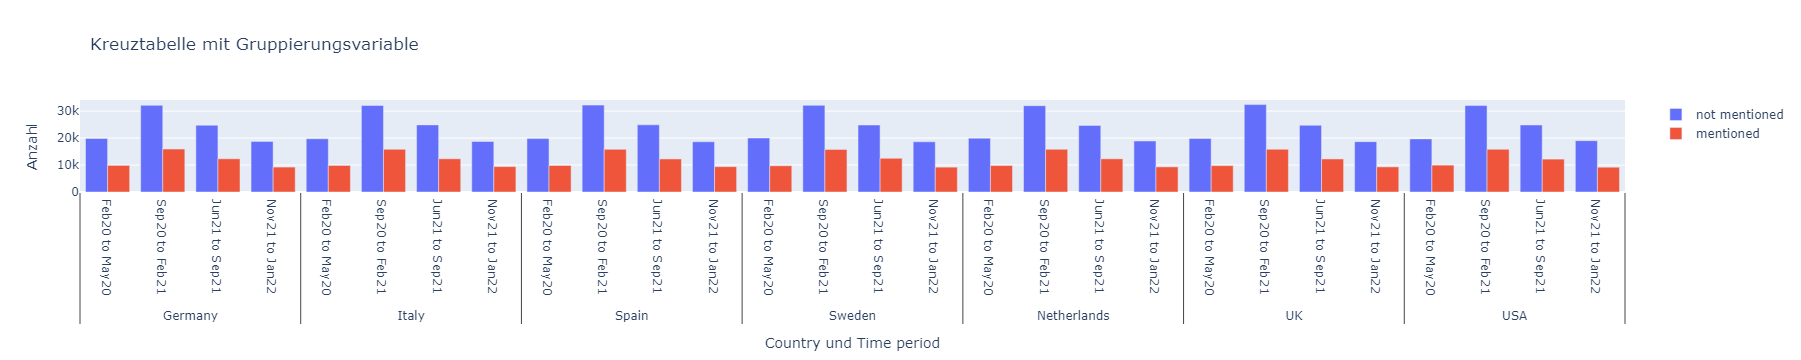

In [9]:
fig = go.Figure()

# Hinzufügen der Balken für jede Kategorie der y_var
for category, values in y_values.items():
    fig.add_trace(go.Bar(
        x=[x_level_1, x_level_2],  # Mehrstufige Achse
        y=values,
        name=category  # Legendenname für die Kategorie
    ))

# Diagramm-Layout anpassen
fig.update_layout(
    title_text="Kreuztabelle mit Gruppierungsvariable",
    xaxis_title=f"{x_var} und {group_var}",
    yaxis_title="Anzahl"
)

fig.show()